In [ ]:
import pandas as pd
from selenium.webdriver.common.by import By
from seleniumbase import Driver

import requests
import time

def get_repo_created_at(repo, token):
    headers = {
        'Authorization': f'token {token}'
    }
    
    base_url = f'https://api.github.com/repos/{repo}'
    
    info = requests.get(base_url, headers=headers).json()
    return info.get('created_at')

driver = Driver(uc=True)
driver.implicitly_wait(5)
driver.get('https://github.com')
time.sleep(30)

df_project = pd.read_csv('all_projects.csv')
token = ''
repo_statistics = {}

for index, row in df_project.iterrows():
    if index < 2119:
        continue
    
    repo = row['repo_link'].split('https://github.com/')[-1]
    
    if repo not in repo_statistics:
        info = {}
        driver.get(row['repo_link'])
        
        try:
            info['commit_count'] = int(driver.find_element(By.XPATH, '//span[@class="Text-sc-17v1xeu-0 gPDEWA fgColor-default"]').text.split(' ')[0].replace(',', ''))
        except:
            print(f'Error: {repo}')
            continue
        
        try:
            contributor_count = driver.find_elements(By.XPATH, f'//a[@href="/{repo}/graphs/contributors"]/span')[0].text
            if contributor_count == '5,000+':
                contributor_count = driver.find_elements(By.XPATH, f'//a[@href="/{repo}/graphs/contributors"]/span')[1].text
                contributor_count = contributor_count.split(' ')[1]
            info['contributor_count'] = int(contributor_count.replace(',', ''))
        except:
            info['contributor_count'] = 1
            
        info['created_at'] = get_repo_created_at(repo, token)    
        print(repo, info)
        repo_statistics[repo] = info
    
    df_project.at[index, 'commit_count'] = repo_statistics[repo]['commit_count']
    df_project.at[index, 'contributor_count'] = repo_statistics[repo]['contributor_count']
    df_project.at[index, 'created_at'] = repo_statistics[repo]['created_at']
    df_project.to_csv('all_projects.csv', index=False)
    time.sleep(1)

driver.quit()

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

# Read and preprocess the project data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_project = pd.read_csv('all_projects.csv')
df_project.drop_duplicates(subset=['repo_link'], inplace=True)
print(f'There are {df_project.shape[0]} unique projects.')
df_project = df_project[df_project['created_at'].notna()]
df_project['ContributorCommitRatio'] = df_project['contributor_count'] / df_project['commit_count']
df_project = df_project[['tool_used', 'ContributorCommitRatio']]

# Read and preprocess the tool data
with pd.ExcelFile('../RQ1-usecases/sbom_tools.xlsx') as excel_file:
    df_tool = pd.read_excel(excel_file, sheet_name='final')
    df_spdx = pd.read_excel(excel_file, sheet_name='SPDXAll')
    df_cdx = pd.read_excel(excel_file, sheet_name='CycloneDXAll')
    df_tool_repo = pd.concat([df_spdx, df_cdx], ignore_index=True)
    df_tool_repo.drop_duplicates(subset=['Name'], inplace=True)
    df_tool_repo = df_tool_repo[df_tool_repo['Repo URL'].notna()]
    df_tool_repo = df_tool_repo[df_tool_repo['Repo URL'].str.contains('github.com')]
    df_tool_repo['tool_used'] = df_tool_repo['Repo URL'].map(lambda x: x.split('/')[-1])
    df_tool = df_tool.merge(df_tool_repo, on='Name')

df_project = df_project.merge(df_tool, on='tool_used')

SBOM_operations = ['BUILD', 'ANALYZE', 'EDIT', 'VIEW', 'DIFF', 'IMPORT', 'TRANSLATE', 'MERGE', 'SUPPORT']
quantitative_metrics = ['ContributorCommitRatio']

# Calculate quartiles for 'ContributorCommitRatio'
df_project['ContributorCommitRatioQuartile'] = pd.qcut(df_project['ContributorCommitRatio'], 4, labels=False)

# Initialize a DataFrame to store the counts of SBOM operations
count_data = pd.DataFrame(index=SBOM_operations, columns=[f'{i+1}' for i in range(4)]).fillna(0)

# Loop through each quartile
for quartile in range(4):
    Quartile_df = df_project[df_project['ContributorCommitRatioQuartile'] == quartile]
    # Loop through each SBOM operation to count the number of tools supporting it
    for operation in SBOM_operations:
        count_data.loc[operation, f'{quartile + 1}'] = (Quartile_df[operation] > 0).sum()

# Create the confusion matrix for chi-square test
confusion_matrix = count_data.astype(int).values

# Perform chi-square test
chi2, p, dof, ex = chi2_contingency(confusion_matrix)

# Calculate Pearson residuals
residuals = (confusion_matrix - ex) / np.sqrt(ex)

# Calculate Cramér's V
n = confusion_matrix.sum()
cramers_v = np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

print("Chi-Square Test Results:")
print(f"p-value: {p}")
print(f"Cramér's V: {cramers_v}")

# Prepare data for scatter heatmap
scatter_data = pd.DataFrame({
    'SBOM_operation': np.repeat(count_data.index, count_data.shape[1]),
    'Quartile': np.tile(count_data.columns, count_data.shape[0]),
    'Pearson residual': residuals.flatten(),
    'Depedency count': count_data.values.flatten()
})

# # Plot scatter heatmap with narrower columns
# plt.figure(figsize=(8, 8))  # Increased figure size
# scatter = sns.scatterplot(
#     data=scatter_data,
#     x='Quartile',
#     y='SBOM_operation',
#     hue='Pearson residual',
#     size='Depedency count',
#     palette='coolwarm_r',
#     sizes=(100, 1600),  # Adjusted size range to reduce overlap
#     legend='brief'
# )

# # Add titles and labels
# plt.xlabel('')
# plt.ylabel('')

# # Adjust the aspect ratio to make columns narrower
# sns.despine(left=True, bottom=True)
# plt.tight_layout()

# # Modify legend text and place it outside the plot
# handles, labels = scatter.get_legend_handles_labels()
# labels[0] = 'Pearson Residual (Size)'
# labels[7] = 'Depedency Count (Color)'
# plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig("scatter_heatmap_SBOM_operations_quartiles.pdf", format='pdf', bbox_inches='tight')
# plt.show()

# scatter_data.groupby('SBOM_operation')[['Depedency count']].sum().reset_index().sort_values('Depedency count', ascending=False)
scatter_data.to_csv('contributor_commit_ratio.csv', index=False)


There are 2426 unique projects.
Chi-Square Test Results:
p-value: 1.020631348419861e-28
Cramér's V: 0.10525968915396965


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_74089/1584704588.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_data = pd.DataFrame(index=SBOM_operations, columns=[f'{i+1}' for i in range(4)]).fillna(0)


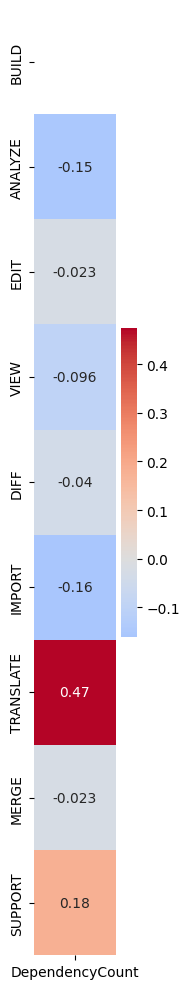

In [73]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_project = pd.read_csv('all_projects.csv')
df_project.drop_duplicates(subset=['repo_link'], inplace=True)
df_project['DependencyCount'] = 1
df_project = df_project.groupby('tool_used').agg({
    'DependencyCount': 'sum',
}).reset_index()

with pd.ExcelFile('../RQ1-usecases/sbom_tools.xlsx') as excel_file:
    df_tool = pd.read_excel(excel_file, sheet_name='final')
    df_spdx = pd.read_excel(excel_file, sheet_name='SPDXAll')
    df_cdx = pd.read_excel(excel_file, sheet_name='CycloneDXAll')
    df_tool_repo = pd.concat([df_spdx, df_cdx], ignore_index=True)
    df_tool_repo = df_tool_repo[df_tool_repo['Repo URL'].notna()]
    df_tool_repo = df_tool_repo[df_tool_repo['Repo URL'].str.contains('github.com')]
    df_tool_repo['Repo'] = df_tool_repo['Repo URL'].map(lambda x: x.split('/')[-1])
    df_tool = df_tool.merge(df_tool_repo, on='Name')

df_tool = df_tool.merge(df_project, left_on='Repo', right_on='tool_used')

SBOM_operations = ['BUILD', 'ANALYZE', 'EDIT', 'VIEW', 'DIFF', 'IMPORT', 'TRANSLATE', 'MERGE', 'SUPPORT']
quantitative_metrics = ['DependencyCount']

# Calculate the correlation matrix
correlation_matrix = df_tool[SBOM_operations + quantitative_metrics].corr()

# Extract the correlation sub-matrix for SBOM_operations and quantitative_metrics
correlation_submatrix = correlation_matrix.loc[SBOM_operations, quantitative_metrics]

import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(2, 10))
sns.heatmap(correlation_submatrix, annot=True, cmap='coolwarm', center=0)
plt.tight_layout()
plt.show()

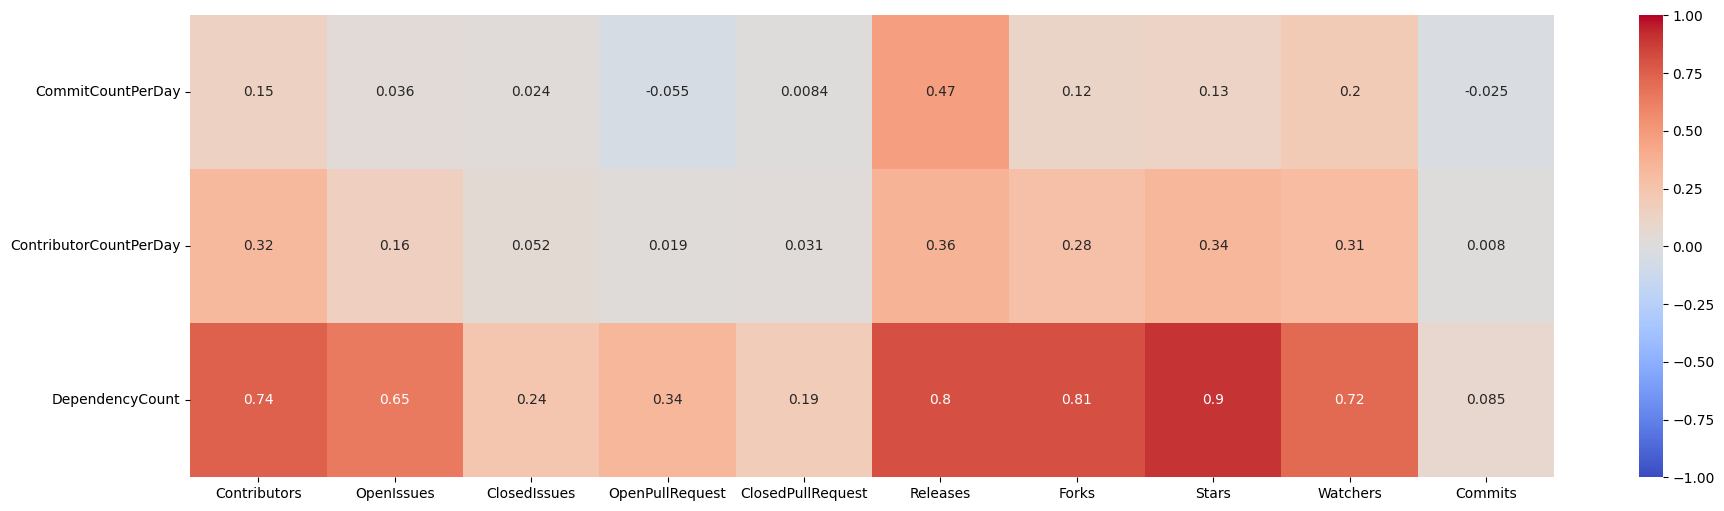

In [33]:
# import pandas as pd

# df_project = pd.read_csv('all_projects.csv')
# df_project.drop_duplicates(subset=['repo_link'], inplace=True)
# df_project['duration'] = (pd.to_datetime('2024-05-31T00:00:00Z') - pd.to_datetime(df_project['created_at'])).dt.days
# df_project['ContributorCountNormalized'] = df_project['contributor_count'] / df_project['duration']
# df_project['CommitCountNormalized'] = df_project['commit_count'] / df_project['duration']
# df_project['DependencyCount'] = 1
# df_project = df_project[['tool_used', 'CommitCountNormalized', 'ContributorCountNormalized', 'DependencyCount']]
# df_project = df_project.groupby('tool_used').sum().reset_index()

# df_tool = pd.read_csv('../RQ2-tools/CycloneNSpdxTools.csv')
# df_tool.drop_duplicates(subset=['Repo'], inplace=True)
# df_tool['tool_used'] = df_tool['Repo'].map(lambda x: x.split('/')[-1])
# df_tool = df_tool.merge(df_project, on='tool_used', how='left')
# target_columns = ['CommitCountNormalized', 'ContributorCountNormalized', 'DependencyCount']

# correlation_matrix = df_tool.corr(numeric_only=True)
# subset_correlations = correlation_matrix.loc[target_columns].drop(target_columns, axis=1)

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(22, 6))
# sns.heatmap(subset_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.savefig("correlation_heatmap.pdf", format='pdf', bbox_inches='tight')
# plt.show()